In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline  
import os
import sys
import gdal
import math
import time
import xarray as xr  
import numpy as np
from scipy.ndimage import rank_filter
from tqdm import tqdm 
import datacube
from datetime import datetime
from scripts.data import drop_empty_data
sys.path.append(r'/home/localuser/Datacube/data_cube_notebooks')
dc = datacube.Datacube(app = 'my_app', config = '/home/localuser/.datacube.conf')
from utils.data_cube_utilities.data_access_api import DataAccessApi
api = DataAccessApi(config= '/home/localuser/.datacube.conf')
from datacube.storage.masking import mask_invalid_data,describe_variable_flags,make_mask
from utils.data_cube_utilities.dc_rgb import rgb
from utils.data_cube_utilities.plotter_utils import figure_ratio, xarray_set_axes_labels, retrieve_or_create_fig_ax
from utils.data_cube_utilities.clean_mask import sentinel2_fmask_clean_mask

## Задаємо параметри

In [2]:
longitude = (30.30, 30.38)
latitude = (50.40, 50.35)
time = (datetime(2019,5,31), datetime(2019,7,31))

In [3]:
data_xr = dc.load(latitude = latitude, 
               longitude = longitude, 
               time = time,
               product = 's2_l2a_kyiv_10m',
               platform = 'SENTINEL_2',
               measurements = ['red', 'green', 'blue','nir', 'slc'])

In [4]:
data_xr

<xarray.Dataset>
Dimensions:  (time: 18, x: 589, y: 578)
Coordinates:
  * time     (time) datetime64[ns] 2019-06-02T09:03:57.500000 ... 2019-07-29T08:52:11
  * y        (y) float64 5.587e+06 5.587e+06 5.587e+06 ... 5.581e+06 5.581e+06
  * x        (x) float64 3.079e+05 3.079e+05 3.079e+05 ... 3.138e+05 3.138e+05
Data variables:
    red      (time, y, x) int16 504 627 692 650 757 ... -9999 -9999 -9999 -9999
    green    (time, y, x) int16 800 836 855 850 872 ... -9999 -9999 -9999 -9999
    blue     (time, y, x) int16 444 507 552 537 617 ... -9999 -9999 -9999 -9999
    nir      (time, y, x) int16 3487 3325 3276 3196 ... -9999 -9999 -9999 -9999
    slc      (time, y, x) uint8 4 4 4 4 4 4 4 4 4 4 4 ... 0 0 0 0 0 0 0 0 0 0 0
Attributes:
    crs:      EPSG:32636

## Cleaning `dataset`

In [5]:
def cleaning_dataset(x_array):
    data = mask_invalid_data(data_xr)
    time_nan_list = []
    for i in data.time.values:
        if math.isnan(data.sel(time = i).red.values[0][0]):
            time_nan_list.append(i)
    return data.drop(time_nan_list, dim='time')

In [5]:
data_xr= drop_empty_data(data_xr)
data_xr

NameError: name 'np' is not defined

## Plotting `RGB` xarray
https://github.com/opendatacube/datacube-notebooks/blob/master/utils/data_cube_utilities/dc_rgb.py

In [89]:
def ploting_rgb_xarray_for_one_day(x_array,time_index, min_possible=0, max_possible=10000,min_inten=0.15, max_inten=1.0,bands = ['red', 'green', 'blue']):
    rgb = np.stack([x_array[bands[0]],
                    x_array[bands[1]],
                    x_array[bands[2]]], axis = -1)
    
    min_rgb =  min_possible
    max_rgb =  max_possible
    rgb = np.interp(rgb, (min_rgb, max_rgb), [min_inten,max_inten])
    rgb = rgb.astype(float)
    fake_saturation = 5000
    #rgb /= fake_saturation  # scale to [0, 1] range for imshow
    figure(figsize=(13,13))
    plt.imshow(rgb[time_index])

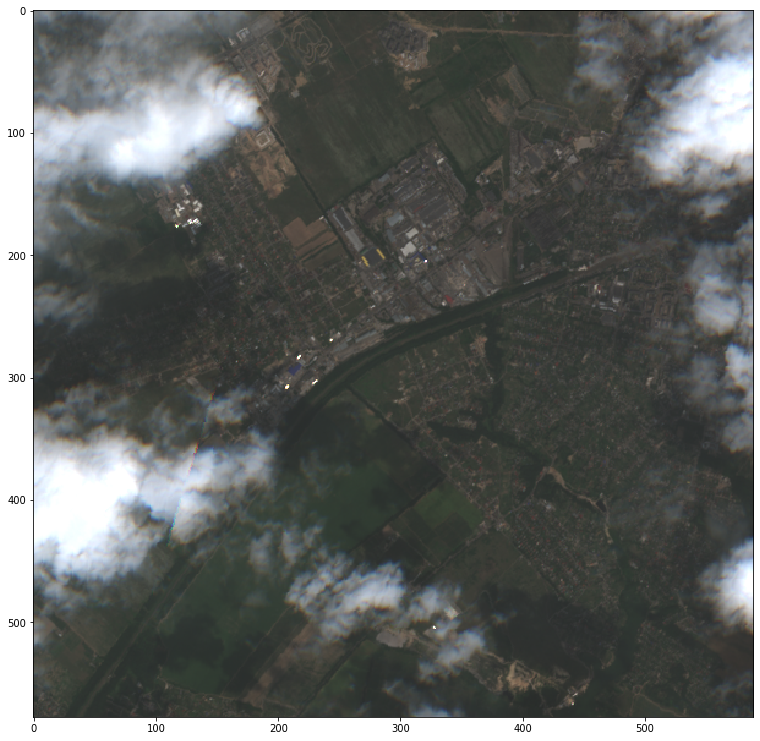

In [90]:
ploting_rgb_xarray_for_one_day(data_xr,2)

In [96]:
def plotting_xarray(x_array):
    dc = datacube.Datacube(app='plot-rgb-recipe')
    data = mask_invalid_data(x_array)
    fake_saturation = 4000
    rgb = data[['red','green','blue']].to_array(dim='color')
    rgb = rgb.transpose(*(rgb.dims[1:]+rgb.dims[:1]))  # make 'color' the last dimension
    rgb = rgb.where((rgb <= fake_saturation).all(dim='color'))  # mask out pixels where any band is 'saturated'
    rgb /= fake_saturation  # scale to [0, 1] range for imshow
    #print(rgb.shape)
    #print(rgb)
    rgb.plot.imshow(x=data.crs.dimensions[1], y=data.crs.dimensions[0],
                col='time', col_wrap=5, add_colorbar=False)

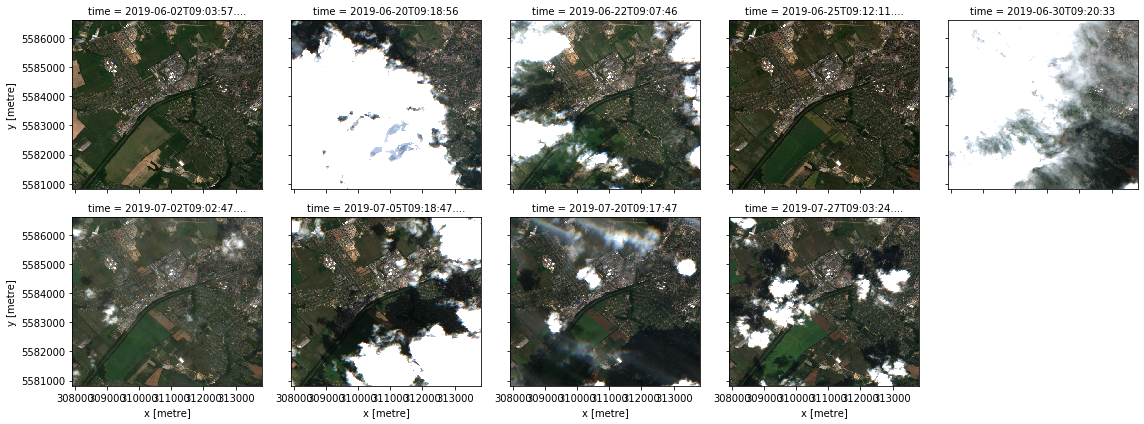

In [97]:
plotting_xarray(data_xr)

In [116]:
def plot_composite(composite,min_possible=0, max_possible=10000,min_inten=0.15, max_inten=1.0):
    """
    composite: - composite with bands RGBN shape(4,x,y)
    """
    composite = composite[[0,1,2],:,:]
    rgb = np.zeros((composite.shape[1],composite.shape[2],composite.shape[0]),dtype=np.int16)
    
    for band in range(rgb.shape[2]):
        rgb[:,:,band]=composite[band,:,:]
    
    min_rgb =  min_possible
    max_rgb =  max_possible
    rgb = np.interp(rgb, (min_rgb, max_rgb), [min_inten,max_inten])
    rgb = rgb.astype(float)
    figure(figsize=(5,5))
    plt.imshow(rgb)

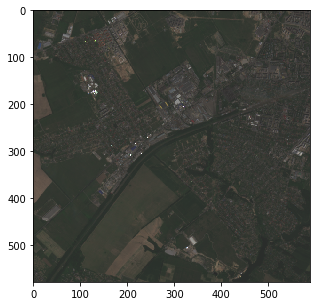

In [117]:
plot_composite(create_composite(data_xr, 0))

## Creating `composite` for one day

In [15]:
def create_composite(x_array, time_index, bands = ['red', 'green', 'blue','nir']):
    '''
    x_array: - dataset
    time_index:  - index of needed day
    '''
    one_day=x_array.sel(time=x_array.time.values[time_index])
    
    rgbn = np.stack([one_day[bands[0]],
                     one_day[bands[1]],
                     one_day[bands[2]],
                     one_day[bands[3]]], axis = -1)    
    return np.moveaxis(rgbn, 2, 0) # moveaxis для того щоб створити масив (4,x,y)

In [16]:
create_composite(data_xr,0)

array([[[ 504.,  627.,  692., ...,  989., 1053., 1383.],
        [ 531.,  639.,  644., ...,  531.,  966., 1435.],
        [ 496.,  543.,  570., ...,  765., 1151., 1470.],
        ...,
        [ 540.,  436.,  680., ...,  452.,  457.,  393.],
        [ 671.,  740.,  708., ...,  482.,  550.,  454.],
        [ 635.,  810.,  913., ...,  566.,  597.,  445.]],

       [[ 800.,  836.,  855., ...,  857., 1013., 1166.],
        [ 817.,  824.,  816., ...,  396.,  792., 1191.],
        [ 801.,  763.,  793., ...,  767., 1268., 1258.],
        ...,
        [ 784.,  575.,  817., ...,  675.,  703.,  531.],
        [ 797.,  817.,  910., ...,  778.,  716.,  683.],
        [ 722.,  971., 1038., ...,  842.,  765.,  647.]],

       [[ 444.,  507.,  552., ...,  722.,  888., 1030.],
        [ 434.,  504.,  525., ...,  433.,  785., 1121.],
        [ 440.,  460.,  473., ...,  756., 1194., 1162.],
        ...,
        [ 512.,  345.,  482., ...,  402.,  441.,  337.],
        [ 584.,  724.,  590., ...,  509.,  45

## Loading `mask`
https://github.com/opendatacube/datacube-notebooks/blob/master/Cloud%20Analysis/SatSummit_Samoa_Landsat_Clouds.ipynb

In [2]:
data_xr.slc

NameError: name 'data_xr' is not defined

In [18]:
def get_mask(x_array, time_index):
    return x_array.slc.sel(time=x_array.time.values[time_index]).values

In [19]:
get_mask(data_xr, 0)

array([[4., 4., 4., ..., 2., 2., 7.],
       [4., 4., 4., ..., 2., 2., 7.],
       [4., 4., 4., ..., 7., 7., 7.],
       ...,
       [4., 4., 4., ..., 4., 4., 4.],
       [4., 4., 4., ..., 4., 4., 4.],
       [4., 4., 4., ..., 4., 4., 4.]])

## `Combining` process

In [61]:
def combiner(x_array, compos_list):
    """
    x_array - our dataset
    compos_list - list of time_index photos where first element is the time_index of base array
    """
    base_array = create_composite(x_array,compos_list[0]).astype('int16')
    base_mask = get_mask(x_array,compos_list[0]).astype('int16') #expand the mask two times  

    #making array mask for base photo
    base_cirrus = base_mask == 10  #cirrus separately to shift it more than other defects
    base_defects = (base_mask == 2) | (base_mask == 3) | (base_mask == 8) | (base_mask == 9)

    
    base_defects = ~rank_filter(~base_defects, rank=3, size = 24)
    base_cirrus = ~rank_filter(~base_cirrus, rank=3, size = 36)

    base_defects = base_defects | base_cirrus
    base_cirrus = None
    
    for itr in compos_list[1:]: # ТУТ ХЗ, коли базова фотка буде друга,  то цикл не буде брать першу 
        # можливе рішення [x for x in range(10) if x != 5]
        
        #open new photo
        new_array = create_composite(x_array,time_index = itr ).astype('int16')
        new_mask = get_mask(x_array,time_index = itr).astype('int16')


        #making array mask for new photo
        new_cirrus =  (new_mask == 10)
        new_defects = (new_mask == 2)  | (new_mask == 3)  | (new_mask == 8)  | (new_mask == 9)  

        
        new_defects = ~rank_filter(~new_defects, rank=3, size = 24) 
        new_cirrus = ~rank_filter(~new_cirrus, rank=3, size = 36)


        new_defects = new_defects | new_cirrus
        new_cirrus = None=

        cond = base_defects & ~new_defects
        base_defects[cond] = False  #modified base mask
        base_array = np.where(cond, new_array, base_array) #modified base array


        if not base_defects.any(): 
            print('All defects are exclude')
            pbar.set_description('Done!')
            break #no more defects
    #else:
        #print('Done!')
        #print('Not enough photos to exclude all the defects.')

    return base_array

In [127]:
def driver(x_array):
    a = time.time()
    d = list(range(len(x_array.time.values)))  # list of index times 
    c = []
    for i in d:
        if i+1 < d[-1]:
            c.append([i,i+1,i+2])
    # now list 'c' looks like [[1,2,3],[2,3,4],...]
    # if you want to take by two photos, just del i+2,then  list 'c' will be looking like [[1,2],[2,3],
    composites = np.empty((len(c),4,x_array.y.shape[0], x_array.x.shape[0]))
    for i in c:
        composites[i[0],:,:,:] = combiner(x_array, compos_list = i) # creating every composite
        print('base', i[0], 'under', i[1:], 'Done!')
    print('TIME FOR ALL COMPOSITES: ',time.time() - a,' seconds')
    return composites

In [128]:
x = driver(data_xr)

base 0 under [1, 2] Done!
base 1 under [2, 3] Done!
base 2 under [3, 4] Done!
base 3 under [4, 5] Done!
base 4 under [5, 6] Done!
base 5 under [6, 7] Done!
base 6 under [7, 8] Done!
TIME FOR ALL COMPOSITES:  41.606263160705566  seconds


## `Ploting` results( ____composites____ )

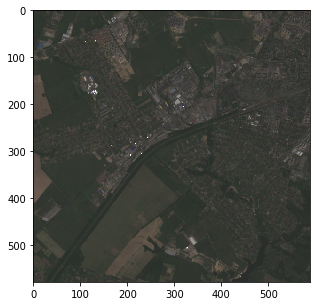

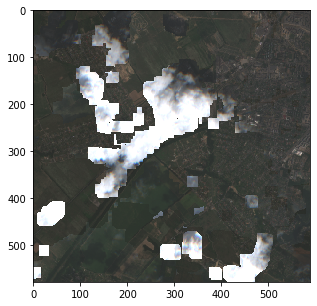

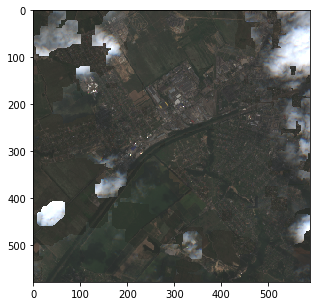

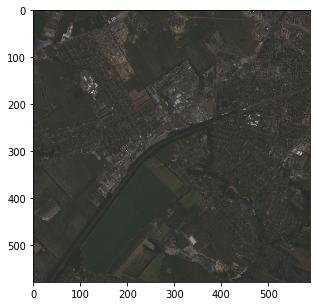

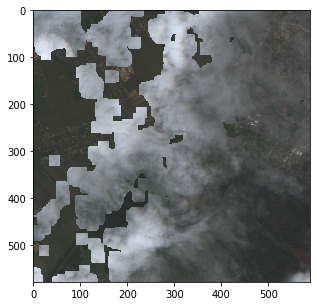

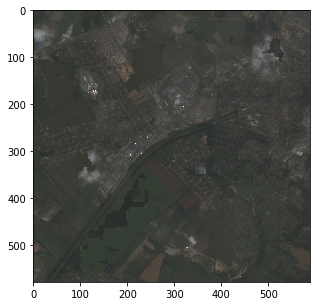

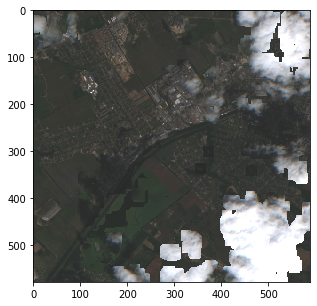

In [129]:
for i in range(x.shape[0]):
    plot_composite(x[i,:,:,:])